# ASR Assignment 2022-23

This notebook has been provided as a template to get you started on the assignment.  Feel free to use it for your development, or do your development directly in Python.

You can find a full description of the assignment [here](http://www.inf.ed.ac.uk/teaching/courses/asr/2022-23/coursework.pdf).

You are provided with two Python modules `observation_model.py` and `wer.py`.  The first was described in [Lab 3](https://github.com/ZhaoZeyu1995/asr_labs/blob/master/asr_lab3_4.ipynb).  The second can be used to compute the number of substitution, deletion and insertion errors between ASR output and a reference text.

It can be used as follows:

```python
import wer

my_refence = 'A B C'
my_output = 'A C C D'

wer.compute_alignment_errors(my_reference, my_output)
```

This produces a tuple $(s,d,i)$ giving counts of substitution,
deletion and insertion errors respectively - in this example (1, 0, 1).  The function accepts either two strings, as in the example above, or two lists.  Matching is case sensitive.

## Template code

Assuming that you have already made a function to generate an WFST, `create_wfst()` and a decoder class, `MyViterbiDecoder`, you can perform recognition on all the audio files as follows:


In [ ]:
import glob
import os
import wer
import observation_model
import openfst_python as fst

# ... (add your code to create WFSTs and Viterbi Decoder)
import observation_model
import math
import openfst_python as fst
import time

class MyViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f, audio_file_name):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()

        
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        
        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j - this removes need for 
                      # extra code to read the output sequence along the best path
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        self.V[0][self.f.start()] = 0.0
        
        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)        
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step(self, t):
        
        forward_computations = 0
          
        for i in self.f.states():
            
            if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        forward_computations += 1
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []
                                
        return forward_computations
                            
    
    def finalise_decoding(self):
        """ this incorporates the probability of terminating at each state
        """
        
        for state in self.f.states():
            final_weight = float(self.f.final(state))
            if self.V[-1][state] != self.NLL_ZERO:
                if final_weight == math.inf:
                    self.V[-1][state] = self.NLL_ZERO  # effectively says that we can't end in this state
                else:
                    self.V[-1][state] += final_weight
                    
        # get a list of all states where there was a path ending with non-zero probability
        finished = [x for x in self.V[-1] if x < self.NLL_ZERO]
        if not finished:  # if empty
            print("No path got to the end of the observations.")
        
        
    def decode(self):
        forward_computations = 0
        initial = time.time()
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            forward_computations += self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            t += 1
        self.finalise_decoding()
        final=time.time()
        return (forward_computations, (final - initial))
    
    def backtrace(self):
        
        initial = time.time()
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state
        
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)
            best_out_sequence = self.W[t][j] + best_out_sequence  # computer scientists might like
                                                                                # to make this more efficient!

            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        # convert the best output sequence from FST integer labels into strings
        
        
        final = time.time()
        # convert the best output sequence from FST integer labels into strings
        best_out_sequence =' '.join([ self.f.output_symbols().find(label) for label in best_out_sequence])
        return (best_state_sequence, best_out_sequence,(final-initial))
import openfst_python as fst

def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.
    
    Args:
        lex_file (str): filename of lexicon file with structure '<word> <phone1> <phone2>...'
                        eg. peppers p eh p er z

    Returns:
        lex (dict): dictionary mapping words to list of phones
    """
    
    lex = {}  # create a dictionary for the lexicon entries (this could be a problem with larger lexica)
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()  # split at each space
            lex[line[0]] = line[1:]  # first field the word, the rest is the phones
    return lex

def generate_symbol_tables(lexicon, n=3):
    '''
    Return word, phone and state symbol tables based on the supplied lexicon
        
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
        n (int): number of states for each phone HMM
        
    Returns:
        word_table (fst.SymbolTable): table of words
        phone_table (fst.SymbolTable): table of phones
        state_table (fst.SymbolTable): table of HMM phone-state IDs
    '''
    
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    
    # add empty <eps> symbol to all tables
    state_table.add_symbol('<eps>')
    phone_table.add_symbol('<eps>')
    word_table.add_symbol('<eps>')
    
    for word, phones  in lexicon.items():
        
        word_table.add_symbol(word)
        
        for p in phones: # for each phone
            
            phone_table.add_symbol(p)
            for i in range(1,n+1): # for each state 1 to n
                state_table.add_symbol('{}_{}'.format(p, i))
            
    return word_table, phone_table, state_table


# call these two functions
lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)
def generate_phone_wfst(f, start_state, phone, n, next_state_prob):
    """
    Generate a WFST representing an n-state left-to-right phone HMM.
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        phone (str): the phone label 
        n (int): number of states of the HMM excluding start and end
        
    Returns:
        the final state of the FST
    """
    
    current_state = start_state
    
    for i in range(1, n+1):
    
        in_label = state_table.find('{}_{}'.format(phone, i))
        sl_weight = fst.Weight('log', -math.log(1-next_state_prob))
        # self-loop back to current state
        f.add_arc(current_state, fst.Arc(in_label, 0, sl_weight, current_state))
        
        # transition to next state
        
        # we want to output the phone label on the final state
        # note: if outputting words instead this code should be modified
        
        out_label = 0   # output empty <eps> label
            
        next_state = f.add_state()
        next_weight = fst.Weight('log', -math.log(next_state_prob))
        f.add_arc(current_state, fst.Arc(in_label, out_label, next_weight, next_state))    
       
        current_state = next_state
    return current_state



def create_wfst(n, probabilities=None, next_state_prob=0.5):
    """ Generate a WFST for any word in the lexicon, composed of n-state phone WFSTs.
        This will currently output phone labels.  
    
    Args:
        
        start_state (int): the index of the first state, assumed to exist already
        word (str): the word to generate
        n (int): states per phone HMM
        
    Returns:
        the constructed WFST
    
    """
    f = fst.Fst('log')
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    f.set_final(start_state)
    start_weight= fst.Weight('log', -math.log(1))
    for word, phones in lex.items():
        if probabilities:
            start_weight = fst.Weight('log', -math.log(probabilities[word]))
        current_state = f.add_state()
        f.add_arc(start_state, fst.Arc(0, 0,start_weight , current_state))
        
        for phone in phones: 
            current_state = generate_phone_wfst(f, current_state, phone, n,next_state_prob)
        # note: new current_state is now set to the final state of the previous phone WFST
        
        next_weight = fst.Weight('log', -math.log(1))
        out_label = word_table.find(word)
        f.add_arc(current_state, fst.Arc(0, out_label,next_weight , start_state))
    f.set_input_symbols(state_table)
    f.set_output_symbols(word_table)

    return f




    


def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription


f = create_wfst(3)

print([x for x in lex.values()])

def num_states(f):
    counter = 0
    for x in f.states():
        counter += 1
    return counter

def total_num_arcs(f):
    return sum(f.num_arcs(s) for s in f.states())

def draw_fst(f):
    from subprocess import check_call
    from IPython.display import Image
    f.draw('tmp.dot', portrait=True)
    check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
    return Image(filename='tmp.png')




draw_fst(f)

    

In [ ]:
#TASK 1

!pip install pandas
import pandas as pd
results_df=[]
import wer

print(num_states(f))
print(total_num_arcs(f))
results_df=[]
for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
                                                                           # audio files
    break
    decoder = MyViterbiDecoder(f, wav_file)
    
    forward_computations, decode_speed = decoder.decode()
    print(decode_speed)
    (state_path, words, backtrace_speed) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
    # to return the words along the best path
    print(backtrace_speed)
    
    transcription = read_transcription(wav_file)
    
    word_count = len(transcription.split())
    



    
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())
    worderror = sum(error_counts)/word_count
         # you'll need to accumulate these to produce an overall Word Error Rate
    filename = wav_file.split('/')[-1]
    row = {
        'Filename': filename,
        'Insertions': error_counts[2],
        'Deletions': error_counts[1],
        'Substitutions': error_counts[0],
        'WER': worderror,
        'Word Count': word_count,
        'transcription':transcription,
        'Viterbi transcription':words,
        'Decode speed': decode_speed,
        'Backtrace speed': backtrace_speed,
        'Forward computations': forward_computations
    }
    print(row)
    
    
    # Append results to the DataFrame
    results_df.append(row)
    
results_df = pd.DataFrame(results_df)
# Save the DataFrame to a CSV file
# results_df.to_csv('resulto.csv')



In [ ]:
from collections import defaultdict
word_count=defaultdict(int)

for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
                                                                           # audio files
    transcription = read_transcription(wav_file)
    for word in transcription.split(" "):
        word_count[word]+=1
total_words = sum(word_count.values())
probabilities ={word:count/total_words for word,count in word_count.items()}
print(word_count,probabilities)

In [ ]:
#TASK 2, using the above probabilities to change the word probabilties
!pip install pandas
import pandas as pd
results_df=[]
import wer
f= create_wfst(3,probabilities)
print(num_states(f))
print(total_num_arcs(f))

for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
    break                     # audio files
    decoder = MyViterbiDecoder(f, wav_file)
    
    forward_computations, decode_speed = decoder.decode()
    print(decode_speed)
    (state_path, words, backtrace_speed) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
    # to return the words along the best path
    print(backtrace_speed)
    
    transcription = read_transcription(wav_file)
    
    word_count = len(transcription.split())
    



    
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())
    worderror = sum(error_counts)/word_count
         # you'll need to accumulate these to produce an overall Word Error Rate
    filename = wav_file.split('/')[-1]
    row = {
        'Filename': filename,
        'Insertions': error_counts[2],
        'Deletions': error_counts[1],
        'Substitutions': error_counts[0],
        'WER': worderror,
        'Word Count': word_count,
        'transcription':transcription,
        'Viterbi transcription':words,
        'Decode speed': decode_speed,
        'Backtrace speed': backtrace_speed,
        'Forward computations': forward_computations
    }
    print(row)
    
    
    # Append results to the DataFrame
    results_df.append(row)
    
results_df = pd.DataFrame(results_df)
# Save the DataFrame to a CSV file
# results_df.to_csv('result_unary.csv')



In [ ]:
#TASK 2, changing self-loop probabilities
!pip install pandas
import pandas as pd
results_df=[]
import wer
f= create_wfst(3,next_state_prob=0.7)
print(num_states(f))
print(total_num_arcs(f))

for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
    break                                                               # audio files
    
    decoder = MyViterbiDecoder(f, wav_file)
    
    forward_computations, decode_speed = decoder.decode()
    print(decode_speed)
    (state_path, words, backtrace_speed) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
    # to return the words along the best path
    print(backtrace_speed)
    
    transcription = read_transcription(wav_file)
    
    word_count = len(transcription.split())
    



    
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())
    worderror = sum(error_counts)/word_count
         # you'll need to accumulate these to produce an overall Word Error Rate
    filename = wav_file.split('/')[-1]
    row = {
        'Filename': filename,
        'Insertions': error_counts[2],
        'Deletions': error_counts[1],
        'Substitutions': error_counts[0],
        'WER': worderror,
        'Word Count': word_count,
        'transcription':transcription,
        'Viterbi transcription':words,
        'Decode speed': decode_speed,
        'Backtrace speed': backtrace_speed,
        'Forward computations': forward_computations
    }
    print(row)
    
    
    # Append results to the DataFrame
    results_df.append(row)
    
results_df = pd.DataFrame(results_df)
# Save the DataFrame to a CSV file
# results_df.to_csv('result_0.7.csv')



In [ ]:
#task2 silent states between states


In [ ]:
from copy import deepcopy



def create_wfst_silent(n, probabilities=None, next_state_prob=0.5, sil_prob=0.5):
    """ Generate a WFST for any word in the lexicon, composed of n-state phone WFSTs."""
    silent_state_table = deepcopy(state_table)
    for i in range(1, 6):
        silent_state_table.add_symbol('sil_{}'.format(i))


    f = fst.Fst('log')
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    f.set_final(start_state)
    start_weight= fst.Weight('log', -math.log(1))
    for word, phones in lex.items():
        out_label = word_table.find(word)
        if probabilities:
            start_weight = fst.Weight('log', -math.log(probabilities[word]))
        current_state = f.add_state()
        f.add_arc(start_state, fst.Arc(0, 0,start_weight , current_state))
        
        for phone in phones: 
            last_state = current_state
            current_state = generate_phone_wfst(f, current_state, phone, n,next_state_prob)
            
        weight = fst.Weight('log',-math.log(1-sil_prob))
        f.add_arc(current_state,fst.Arc(0,out_label,weight,start_state))
        weight = fst.Weight('log',-math.log(sil_prob*(1-next_state_prob)))
        f.add_arc(current_state,fst.Arc(silent_state_table.find('sil_1'),0,weight,current_state))
        next_state =f.add_state()
        weight = fst.Weight('log',-math.log(sil_prob*((1-next_state_prob))))
        f.add_arc(current_state,fst.Arc(silent_state_table.find('sil_1'),0,weight,next_state))
        current_state=next_state
        
        
        for i in range(2,6):
            weight = fst.Weight('log',-math.log(1-next_state_prob))
            f.add_arc(current_state,fst.Arc(silent_state_table.find('sil_{}'.format(i)),0,weight,current_state))
            next_state =f.add_state()
            weight = fst.Weight('log',-math.log(next_state_prob))
            f.add_arc(current_state,fst.Arc(silent_state_table.find('sil_{}'.format(i)),0,weight,next_state))
            current_state=next_state
        

            
            
            
            
            
        
        
        
        next_weight = fst.Weight('log', -math.log(1))
        f.add_arc(current_state, fst.Arc(0, out_label,next_weight , start_state))
    f.set_input_symbols(silent_state_table)
    f.set_output_symbols(word_table)


    return f


In [ ]:
f=create_wfst_silent(3,sil_prob=0.6)

In [ ]:
draw_fst(f)

In [11]:
results_df=[]
f= create_wfst_silent(3,sil_prob=0.7)
print(num_states(f))
print(total_num_arcs(f))

for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
                                                                          # audio files
    decoder = MyViterbiDecoder(f, wav_file)
    
    forward_computations, decode_speed = decoder.decode()
    print(decode_speed)
    (state_path, words, backtrace_speed) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
    # to return the words along the best path
    print(backtrace_speed)
    
    transcription = read_transcription(wav_file)
    
    word_count = len(transcription.split())
    



    
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())
    worderror = sum(error_counts)/word_count
         # you'll need to accumulate these to produce an overall Word Error Rate
    filename = wav_file.split('/')[-1]
    row = {
        'Filename': filename,
        'Insertions': error_counts[2],
        'Deletions': error_counts[1],
        'Substitutions': error_counts[0],
        'WER': worderror,
        'Word Count': word_count,
        'transcription':transcription,
        'Viterbi transcription':words,
        'Decode speed': decode_speed,
        'Backtrace speed': backtrace_speed,
        'Forward computations': forward_computations
    }
    print(row)
    
    
    # Append results to the DataFrame
    results_df.append(row)
    
results_df = pd.DataFrame(results_df)
# Save the DataFrame to a CSV file
results_df.to_csv('result_silent_0.7.csv')


166
340
7.930864095687866
0.0007605552673339844
{'Filename': '0000.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.11764705882352941, 'Word Count': 17, 'transcription': "peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked", 'Viterbi transcription': "pickled peter piper picked a the peck of pickled peppers where's the peck of pickled peppers peter piper picked", 'Decode speed': 7.930864095687866, 'Backtrace speed': 0.0007605552673339844, 'Forward computations': 354068}
4.490898609161377
0.000316619873046875
{'Filename': '0001.wav', 'Insertions': 3, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.5714285714285714, 'Word Count': 7, 'transcription': 'peter picked a peck of pickled peppers', 'Viterbi transcription': 'pickled a peter picked the of peck of pickled peppers', 'Decode speed': 4.490898609161377, 'Backtrace speed': 0.000316619873046875, 'Forward computations': 200618}
3.336289405822754
0.00020241737365722656
{'Filena

4.958715200424194
0.0003628730773925781
{'Filename': '0022.wav', 'Insertions': 10, 'Deletions': 0, 'Substitutions': 1, 'WER': 1.375, 'Word Count': 8, 'transcription': 'peter piper piper peter peter peter piper piper', 'Viterbi transcription': 'a the picked peck piper the of piper the peter peter of peter of piper the of piper', 'Decode speed': 4.958715200424194, 'Backtrace speed': 0.0003628730773925781, 'Forward computations': 221698}
3.203254461288452
0.0001647472381591797
{'Filename': '0023.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.5, 'Word Count': 4, 'transcription': 'peter picked piper peppers', 'Viterbi transcription': 'a peter of picked piper peppers', 'Decode speed': 3.203254461288452, 'Backtrace speed': 0.0001647472381591797, 'Forward computations': 143888}
3.587308645248413
0.00020384788513183594
{'Filename': '0024.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 2, 'WER': 0.6666666666666666, 'Word Count': 6, 'transcription': 'peter peter peter

2.564821243286133
0.00013494491577148438
{'Filename': '0043.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 2, 'WER': 0.5714285714285714, 'Word Count': 7, 'transcription': "where's the peck of peppers piper pickled", 'Viterbi transcription': "a where's of a of peppers piper of pickled", 'Decode speed': 2.564821243286133, 'Backtrace speed': 0.00013494491577148438, 'Forward computations': 115988}
2.9791059494018555
0.0001678466796875
{'Filename': '0044.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 2, 'WER': 0.5, 'Word Count': 8, 'transcription': 'piper pickled peppers of the peck peter picked', 'Viterbi transcription': 'a piper of pickled peppers of the piper peter peck', 'Decode speed': 2.9791059494018555, 'Backtrace speed': 0.0001678466796875, 'Forward computations': 134588}
2.917952299118042
0.0002257823944091797
{'Filename': '0045.wav', 'Insertions': 1, 'Deletions': 0, 'Substitutions': 4, 'WER': 0.8333333333333334, 'Word Count': 6, 'transcription': 'piper peter pick

3.4897706508636475
0.0002799034118652344
{'Filename': '0063.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 4, 'WER': 0.8571428571428571, 'Word Count': 7, 'transcription': "peter piper picked where's the peck of", 'Viterbi transcription': "a picked of piper a where's of peck pickled", 'Decode speed': 3.4897706508636475, 'Backtrace speed': 0.0002799034118652344, 'Forward computations': 158148}
5.04118275642395
0.0005261898040771484
{'Filename': '0064.wav', 'Insertions': 3, 'Deletions': 1, 'Substitutions': 4, 'WER': 0.6666666666666666, 'Word Count': 12, 'transcription': 'pickled peppers pickled peppers peter piper picked a peck of pickled peppers', 'Viterbi transcription': "a pickled where's pickled peppers picked of piper a of a of picked peppers", 'Decode speed': 5.04118275642395, 'Backtrace speed': 0.0005261898040771484, 'Forward computations': 230068}
3.6714060306549072
0.0003330707550048828
{'Filename': '0065.wav', 'Insertions': 3, 'Deletions': 0, 'Substitutions': 2, 'WER': 

1.6950900554656982
0.00010251998901367188
{'Filename': '0084.wav', 'Insertions': 1, 'Deletions': 4, 'Substitutions': 0, 'WER': 0.5555555555555556, 'Word Count': 9, 'transcription': "where's the peck of pickled peppers peter piper picked", 'Viterbi transcription': 'pickled peppers peter of piper picked', 'Decode speed': 1.6950900554656982, 'Backtrace speed': 0.00010251998901367188, 'Forward computations': 76308}
2.319826602935791
0.00032973289489746094
{'Filename': '0085.wav', 'Insertions': 2, 'Deletions': 1, 'Substitutions': 3, 'WER': 0.5454545454545454, 'Word Count': 11, 'transcription': 'the peck of pickled peppers picked a peck of pickled peppers', 'Viterbi transcription': "peck of pickled peppers picked of peck of peck of peck where's", 'Decode speed': 2.319826602935791, 'Backtrace speed': 0.00032973289489746094, 'Forward computations': 105448}
2.9239346981048584
0.0002593994140625
{'Filename': '0086.wav', 'Insertions': 3, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.5, 'Word Count

3.2479801177978516
0.0002970695495605469
{'Filename': '0104.wav', 'Insertions': 4, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.8333333333333334, 'Word Count': 6, 'transcription': 'peter picked peppers of pickled peppers', 'Viterbi transcription': 'a peter picked a peppers of pickled picked picked a', 'Decode speed': 3.2479801177978516, 'Backtrace speed': 0.0002970695495605469, 'Forward computations': 146678}
3.99235463142395
0.00040411949157714844
{'Filename': '0105.wav', 'Insertions': 1, 'Deletions': 1, 'Substitutions': 1, 'WER': 0.3333333333333333, 'Word Count': 9, 'transcription': 'peter peppers picked piper a peck of pickled peppers', 'Viterbi transcription': 'a peter peppers a piper peck of pickled peppers', 'Decode speed': 3.99235463142395, 'Backtrace speed': 0.00040411949157714844, 'Forward computations': 181088}
3.5517022609710693
0.00034332275390625
{'Filename': '0106.wav', 'Insertions': 2, 'Deletions': 1, 'Substitutions': 1, 'WER': 0.5, 'Word Count': 8, 'transcription': 'pet

2.071695566177368
0.00012755393981933594
{'Filename': '0126.wav', 'Insertions': 3, 'Deletions': 0, 'Substitutions': 3, 'WER': 1.5, 'Word Count': 4, 'transcription': 'piper peppers peter picked', 'Viterbi transcription': 'a of peck of peter of the', 'Decode speed': 2.071695566177368, 'Backtrace speed': 0.00012755393981933594, 'Forward computations': 94908}
2.236746072769165
0.0001850128173828125
{'Filename': '0127.wav', 'Insertions': 0, 'Deletions': 1, 'Substitutions': 1, 'WER': 0.4, 'Word Count': 5, 'transcription': 'a peck of pickled peppers', 'Viterbi transcription': 'a peck pickled a', 'Decode speed': 2.236746072769165, 'Backtrace speed': 0.0001850128173828125, 'Forward computations': 100178}
1.8208026885986328
0.0001461505889892578
{'Filename': '0128.wav', 'Insertions': 1, 'Deletions': 0, 'Substitutions': 0, 'WER': 0.3333333333333333, 'Word Count': 3, 'transcription': 'piper pickled pickled', 'Viterbi transcription': 'a piper pickled pickled', 'Decode speed': 1.8208026885986328, 'B

2.8787662982940674
0.0002429485321044922
{'Filename': '0148.wav', 'Insertions': 3, 'Deletions': 0, 'Substitutions': 1, 'WER': 1.0, 'Word Count': 4, 'transcription': 'peter picked pickled peppers', 'Viterbi transcription': "a peter picked the pickled peck where's", 'Decode speed': 2.8787662982940674, 'Backtrace speed': 0.0002429485321044922, 'Forward computations': 131798}
2.3858678340911865
0.00015735626220703125
{'Filename': '0149.wav', 'Insertions': 1, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.3333333333333333, 'Word Count': 6, 'transcription': 'peter picked a peck of peppers', 'Viterbi transcription': 'a peter picked of peck of peppers', 'Decode speed': 2.3858678340911865, 'Backtrace speed': 0.00015735626220703125, 'Forward computations': 107928}
2.2665936946868896
0.00014734268188476562
{'Filename': '0150.wav', 'Insertions': 1, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.3333333333333333, 'Word Count': 6, 'transcription': 'peter picked a peck of peppers', 'Viterbi transcription

3.56185245513916
0.0004067420959472656
{'Filename': '0169.wav', 'Insertions': 1, 'Deletions': 1, 'Substitutions': 1, 'WER': 0.3, 'Word Count': 10, 'transcription': "peter piper picked a peck where's the peck peter picked", 'Viterbi transcription': "a peter piper picked of peck where's peck peter picked", 'Decode speed': 3.56185245513916, 'Backtrace speed': 0.0004067420959472656, 'Forward computations': 160938}
2.675624132156372
0.00018405914306640625
{'Filename': '0170.wav', 'Insertions': 1, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.4, 'Word Count': 5, 'transcription': 'peter piper picked pickled peppers', 'Viterbi transcription': 'a picked piper picked pickled peppers', 'Decode speed': 2.675624132156372, 'Backtrace speed': 0.00018405914306640625, 'Forward computations': 121258}
3.555018901824951
0.00033736228942871094
{'Filename': '0171.wav', 'Insertions': 3, 'Deletions': 0, 'Substitutions': 3, 'WER': 0.75, 'Word Count': 8, 'transcription': "peter piper picked pickled peppers where

8.051446199417114
0.0009710788726806641
{'Filename': '0190.wav', 'Insertions': 5, 'Deletions': 0, 'Substitutions': 3, 'WER': 0.47058823529411764, 'Word Count': 17, 'transcription': "piper pickled picked peppers of picked a pickled piper the peppers peck of peter peter peck where's", 'Viterbi transcription': "a piper of pickled picked peppers of picked of pickled picked of the picked of where's peck of peter peter peck where's", 'Decode speed': 8.051446199417114, 'Backtrace speed': 0.0009710788726806641, 'Forward computations': 362128}
9.788434028625488
0.0011205673217773438
{'Filename': '0191.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 5, 'WER': 0.4117647058823529, 'Word Count': 17, 'transcription': "a peter the of peck where's piper peter picked pickled picked peppers pickled of peck peppers piper", 'Viterbi transcription': "a of peter pickled of peck where's piper peter a pickled pickled of where's pickled of peck where's piper", 'Decode speed': 9.788434028625488, 'Backtr

2.638252019882202
0.00032520294189453125
{'Filename': '0207.wav', 'Insertions': 2, 'Deletions': 1, 'Substitutions': 2, 'WER': 0.625, 'Word Count': 8, 'transcription': 'peter piper picked a peck of pickled peppers', 'Viterbi transcription': "a peter of piper picked of peck pickled where's", 'Decode speed': 2.638252019882202, 'Backtrace speed': 0.00032520294189453125, 'Forward computations': 121258}
2.8017656803131104
0.00037741661071777344
{'Filename': '0208.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 5, 'WER': 0.7777777777777778, 'Word Count': 9, 'transcription': "where's the peck of pickled peppers peter piper picked", 'Viterbi transcription': "a where's of of of picked peppers picked of of picked", 'Decode speed': 2.8017656803131104, 'Backtrace speed': 0.00037741661071777344, 'Forward computations': 126528}
2.6247594356536865
0.0003638267517089844
{'Filename': '0209.wav', 'Insertions': 1, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.3333333333333333, 'Word Count': 6, 'tra

2.006004810333252
0.0001399517059326172
{'Filename': '0226.wav', 'Insertions': 1, 'Deletions': 1, 'Substitutions': 1, 'WER': 0.5, 'Word Count': 6, 'transcription': "where's the piper of peck peter", 'Viterbi transcription': "a where's peppers of peck peter", 'Decode speed': 2.006004810333252, 'Backtrace speed': 0.0001399517059326172, 'Forward computations': 89638}
2.2833364009857178
0.00016450881958007812
{'Filename': '0227.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 4, 'WER': 0.8571428571428571, 'Word Count': 7, 'transcription': 'peter picked a peck of pickled peppers', 'Viterbi transcription': "a the of picked the peck of picked where's", 'Decode speed': 2.2833364009857178, 'Backtrace speed': 0.00016450881958007812, 'Forward computations': 102658}
2.0418026447296143
0.00014209747314453125
{'Filename': '0228.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 3, 'WER': 0.7142857142857143, 'Word Count': 7, 'transcription': 'peter piper picked a peck of peppers', 'Viterb

3.168975830078125
0.0001895427703857422
{'Filename': '0247.wav', 'Insertions': 1, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.6666666666666666, 'Word Count': 3, 'transcription': 'piper picked peter', 'Viterbi transcription': 'a piper pickled peter', 'Decode speed': 3.168975830078125, 'Backtrace speed': 0.0001895427703857422, 'Forward computations': 142338}
3.1804380416870117
0.00021409988403320312
{'Filename': '0248.wav', 'Insertions': 3, 'Deletions': 0, 'Substitutions': 2, 'WER': 1.25, 'Word Count': 4, 'transcription': 'peter peter piper peppers', 'Viterbi transcription': "a peter picked of piper of where's", 'Decode speed': 3.1804380416870117, 'Backtrace speed': 0.00021409988403320312, 'Forward computations': 145128}
2.4471802711486816
0.00013208389282226562
{'Filename': '0249.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.5, 'Word Count': 6, 'transcription': 'pickled piper peter peck of peppers', 'Viterbi transcription': 'a pickled piper the the peck of peppers

2.5994045734405518
0.00014781951904296875
{'Filename': '0266.wav', 'Insertions': 1, 'Deletions': 1, 'Substitutions': 3, 'WER': 0.8333333333333334, 'Word Count': 6, 'transcription': "where's peter piper pickled picked peppers", 'Viterbi transcription': "a where's of of pickled a", 'Decode speed': 2.5994045734405518, 'Backtrace speed': 0.00014781951904296875, 'Forward computations': 115988}
1.8804740905761719
0.00046062469482421875
{'Filename': '0267.wav', 'Insertions': 1, 'Deletions': 0, 'Substitutions': 4, 'WER': 0.8333333333333334, 'Word Count': 6, 'transcription': 'the peck of peppers peter picked', 'Viterbi transcription': "a the of of where's the a", 'Decode speed': 1.8804740905761719, 'Backtrace speed': 0.00046062469482421875, 'Forward computations': 84368}
1.8958485126495361
9.632110595703125e-05
{'Filename': '0268.wav', 'Insertions': 0, 'Deletions': 2, 'Substitutions': 2, 'WER': 0.6666666666666666, 'Word Count': 6, 'transcription': "where's the pickled peck of peppers", 'Viterbi

2.6171228885650635
0.00014853477478027344
{'Filename': '0288.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 2, 'WER': 0.6666666666666666, 'Word Count': 6, 'transcription': 'peppers pickled a peck picked peter', 'Viterbi transcription': "a of where's pickled of peck picked peter", 'Decode speed': 2.6171228885650635, 'Backtrace speed': 0.00014853477478027344, 'Forward computations': 118778}
1.6350436210632324
0.00045680999755859375
{'Filename': '0289.wav', 'Insertions': 1, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.6666666666666666, 'Word Count': 3, 'transcription': 'peter picked peppers', 'Viterbi transcription': "a where's picked peppers", 'Decode speed': 1.6350436210632324, 'Backtrace speed': 0.00045680999755859375, 'Forward computations': 73518}
1.7768528461456299
9.608268737792969e-05
{'Filename': '0290.wav', 'Insertions': 1, 'Deletions': 0, 'Substitutions': 2, 'WER': 0.75, 'Word Count': 4, 'transcription': 'peck of pickled peppers', 'Viterbi transcription': "a picked of 

6.954690933227539
0.0016133785247802734
{'Filename': '0310.wav', 'Insertions': 8, 'Deletions': 0, 'Substitutions': 10, 'WER': 1.0588235294117647, 'Word Count': 17, 'transcription': "peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked", 'Viterbi transcription': "a the picked of piper the a pickled where's peck picked where's where's peck of of peppers peppers peter a the a peck where's peck", 'Decode speed': 6.954690933227539, 'Backtrace speed': 0.0016133785247802734, 'Forward computations': 314388}
3.611083745956421
0.00020432472229003906
{'Filename': '0311.wav', 'Insertions': 2, 'Deletions': 0, 'Substitutions': 1, 'WER': 0.6, 'Word Count': 5, 'transcription': 'a peck of pickled peppers', 'Viterbi transcription': "a peck of pickled of where's piper", 'Decode speed': 3.611083745956421, 'Backtrace speed': 0.00020432472229003906, 'Forward computations': 163728}
1.841909646987915
9.775161743164062e-05
{'Filename': '0312.wav', 'Insertions': 3,

In [11]:
#task 3 pruning

#attempt using beam search
"""
what is beam search?




"""
class PrunedViterbiDecoder:
    
    
    NLL_ZERO = 1e10# define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f, audio_file_name,beam=30, beam_type = "size"):
        """Set up the decoder class with an audio file and WFST f
        """
        self.NLL_ZERO = 1e10
        self.om = observation_model.ObservationModel()
        self.f = f
        self.beam = beam
        self.beam_type = beam_type
        if beam_type != "size" and beam_type != "width":
            raise Exception("beam_type must be of size or width")
        
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()

        
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        
        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j - this removes need for 
                      # extra code to read the output sequence along the best path
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        self.V[0][self.f.start()] = 0.0
        
        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)        
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step(self, t):
        
        forward_computations = 0
          
        for i in self.f.states():
            
            if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        forward_computations += 1
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []
                                
                                
        if self.beam_type == "width":
            minimum_state_value = min(self.V[t])
            print(minimum_state_value)
            for j in range(self.f.num_states()):
                if self.V[t][j] > -math.log(self.beam) + minimum_state_value:
                    self.V[t][j] = self.NLL_ZERO 
            print(minimum_state_value)
        
        if self.beam_type == "size": 
            sorted_values = sorted(self.V[t])
            beam = min(self.beam, len(self.V[t]))
            threshold = sorted_values[self.beam - 1]
            for j in range(f.num_states()):
                if self.V[t][j] > threshold:
                    self.V[t][j] = self.NLL_ZERO 
        
                                
        return forward_computations
                            
    
    def finalise_decoding(self):
        """ this incorporates the probability of terminating at each state
        """
        
        for state in self.f.states():
            final_weight = float(self.f.final(state))
            if self.V[-1][state] != self.NLL_ZERO:
                if final_weight == math.inf:
                    self.V[-1][state] = self.NLL_ZERO  # effectively says that we can't end in this state
                else:
                    self.V[-1][state] += final_weight
                    
        # get a list of all states where there was a path ending with non-zero probability
        finished = [x for x in self.V[-1] if x < self.NLL_ZERO]
        if not finished:  # if empty
            print("No path got to the end of the observations.")
        
        
    def decode(self):
        forward_computations = 0
        initial = time.time()
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            forward_computations += self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            t += 1
        self.finalise_decoding()
        final=time.time()
        return (forward_computations, (final - initial))
    
    def backtrace(self):
        
        initial = time.time()
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state
        
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)
            best_out_sequence = self.W[t][j] + best_out_sequence  # computer scientists might like
                                                                                # to make this more efficient!

            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        # convert the best output sequence from FST integer labels into strings
        
        
        final = time.time()
        # convert the best output sequence from FST integer labels into strings
        best_out_sequence =' '.join([ self.f.output_symbols().find(label) for label in best_out_sequence])
        
        return (best_state_sequence, best_out_sequence,(final-initial))
    

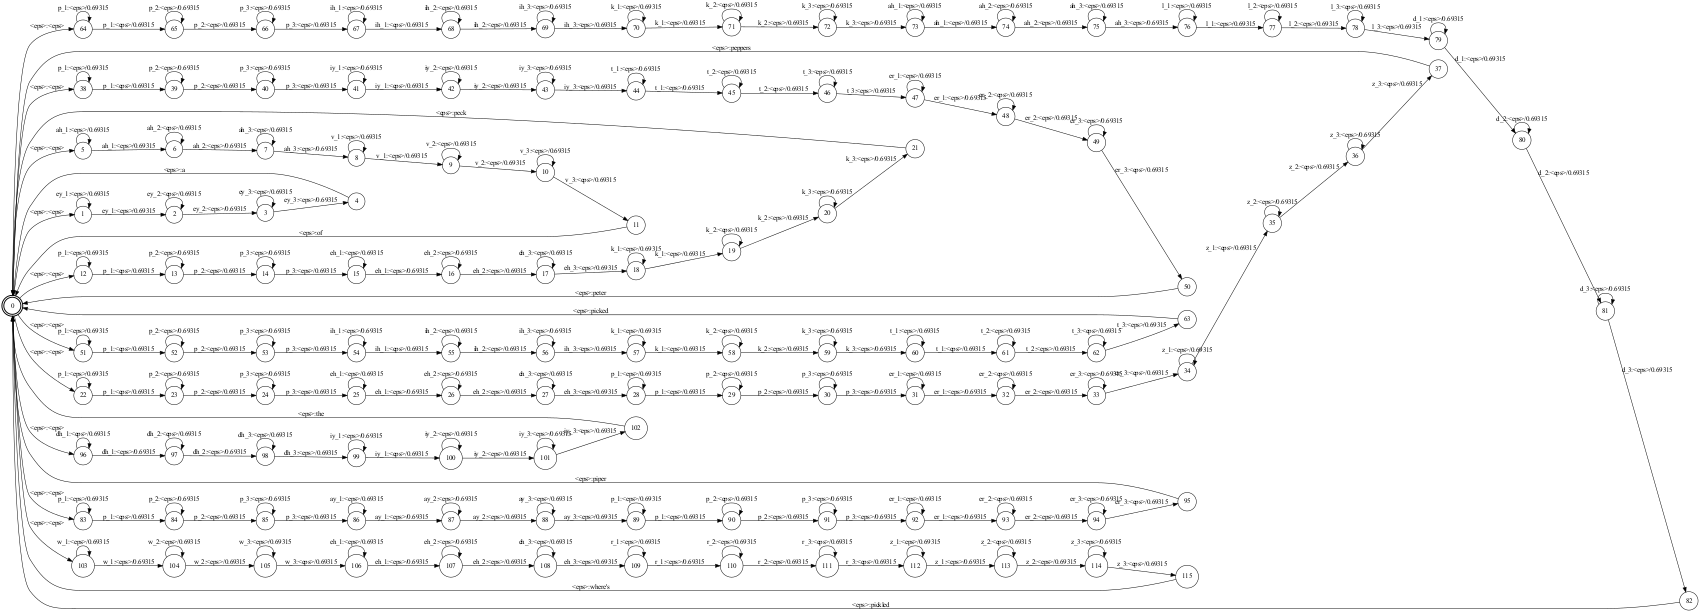

In [12]:
f=create_wfst(3)
draw_fst(f)

In [14]:
#TASK 2, changing self-loop probabilities


print(num_states(f))
print(total_num_arcs(f))
f=create_wfst_silent(3,probabilities,next_state_prob=0.1,sil_prob=0.5)
results_df=[]
for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'): 
    break# replace path if using your own
                                                                      # audio files
    decoder = PrunedViterbiDecoder(f, wav_file,beam=50,beam_type="size")
    
    forward_computations, decode_speed = decoder.decode()
    print(decode_speed)
    (state_path, words, backtrace_speed) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
    # to return the words along the best path
    print(backtrace_speed)
    
    transcription = read_transcription(wav_file)
    
    word_count = len(transcription.split())
    



    
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())
    worderror = sum(error_counts)/word_count
         # you'll need to accumulate these to produce an overall Word Error Rate
    filename = wav_file.split('/')[-1]
    row = {
        'Filename': filename,
        'Insertions': error_counts[2],
        'Deletions': error_counts[1],
        'Substitutions': error_counts[0],
        'WER': worderror,
        'Word Count': word_count,
        'transcription':transcription,
        'Viterbi transcription':words,
        'Decode speed': decode_speed,
        'Backtrace speed': backtrace_speed,
        'Forward computations': forward_computations
    }
    print(row)
    
    
    # Append results to the DataFrame
    results_df.append(row)
    
    
results_df = pd.DataFrame(results_df)
# Save the DataFrame to a CSV file
# results_df.to_csv('result_pruned_size_50.csv')



116
230


In [15]:
#task 4
#Bigram Probabilities

from collections import defaultdict
bigram_count=defaultdict(int)
word_count = defaultdict(int)


for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
                                                                           # audio files
    transcription = read_transcription(wav_file)
    transcription = "<s> "+ str(transcription)+" </s>"
    transcription = transcription.split(" ")
    for i in range(0,len(transcription)-1):
        bigram = transcription[i]+ " "+transcription[i+1]
        bigram_count[bigram]+=1
        word_count[transcription[i]]+=1
bigram_prob = {}

for bigram in bigram_count.keys():
    word = bigram.split()[0]

    bigram_prob[bigram]= bigram_count[bigram] / word_count[word]
bigram_prob

# probabilities ={bigram:count/total_words for word,count in word_count.items()}
# print(word_count,bigram_probabilities)

{'<s> peter': 0.3677811550151976,
 'peter piper': 0.5384615384615384,
 'piper picked': 0.5501730103806228,
 'picked a': 0.2972027972027972,
 'a peck': 0.7608695652173914,
 'peck of': 0.7083333333333334,
 'of pickled': 0.6219512195121951,
 'pickled peppers': 0.6947368421052632,
 "peppers where's": 0.09968847352024922,
 "where's the": 0.6864406779661016,
 'the peck': 0.6861313868613139,
 'peppers peter': 0.24922118380062305,
 'picked </s>': 0.34265734265734266,
 'peter picked': 0.17751479289940827,
 'peppers </s>': 0.3707165109034268,
 '<s> a': 0.07598784194528875,
 'peppers picked': 0.07476635514018691,
 'piper peter': 0.0657439446366782,
 'piper </s>': 0.12802768166089964,
 "<s> where's": 0.1762917933130699,
 'piper pickled': 0.07958477508650519,
 "where's peter": 0.1440677966101695,
 'peter </s>': 0.08284023668639054,
 '<s> piper': 0.1033434650455927,
 'picked peppers': 0.09090909090909091,
 'peppers of': 0.056074766355140186,
 'of peter': 0.04878048780487805,
 'peter peppers': 0.0414

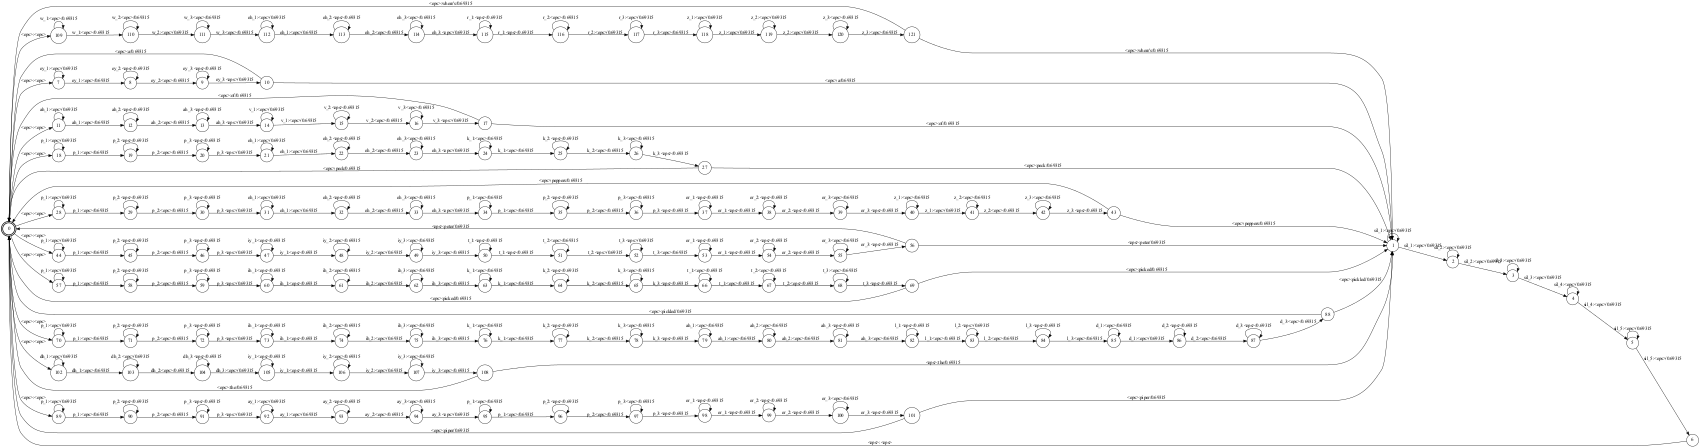

In [16]:
#task 4 reducing the number of states in wfst by having silence be connected for all
def create_wfst_silent_2(n, probabilities=None, next_state_prob=0.5, sil_prob=0.5):
    """ Generate a WFST for any word in the lexicon, composed of n-state phone WFSTs."""
    silent_state_table = deepcopy(state_table)
    for i in range(1, 6):
        silent_state_table.add_symbol('sil_{}'.format(i))


    f = fst.Fst('log')
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    f.set_final(start_state)
    start_weight= fst.Weight('log', -math.log(1))
    
    this_state = f.add_state()
    first_sil = this_state
    for i in range(1,6):
        weight = fst.Weight('log',-math.log(1-next_state_prob))
        
        f.add_arc(this_state,fst.Arc(silent_state_table.find('sil_{}'.format(i)),0, weight, this_state))
        next_state= f.add_state()
        weight = fst.Weight('log',-math.log(next_state_prob))
        f.add_arc(this_state,fst.Arc(silent_state_table.find('sil_{}'.format(i)),0,weight,next_state))
        this_state=next_state
    
    weight = fst.Weight('log',-math.log(1))
    f.add_arc(this_state,fst.Arc(0,0, weight, start_state))

    
    for word, phones in lex.items():
        out_label = word_table.find(word)
        if probabilities:
            start_weight = fst.Weight('log', -math.log(probabilities[word]))
        current_state = f.add_state()
        f.add_arc(start_state, fst.Arc(0, 0,start_weight , current_state))
        
        for phone in phones: 
            last_state = current_state
            current_state = generate_phone_wfst(f, current_state, phone, n, 0.5)
            
        weight = fst.Weight('log',-math.log(1-sil_prob))
        f.add_arc(current_state,fst.Arc(0,out_label,weight,start_state))
        weight = fst.Weight('log',-math.log(sil_prob))
        f.add_arc(current_state,fst.Arc(0,out_label,weight,first_sil))
        
        

        

            
            
            

    f.set_input_symbols(silent_state_table)
    f.set_output_symbols(word_table)


    return f

    
f=create_wfst_silent_2(3)
draw_fst(f)

In [17]:

print(num_states(f))
print(total_num_arcs(f))
f=create_wfst_silent(3,probabilities,next_state_prob=0.1,sil_prob=0.5)
results_df=[]
for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
    break                                                                  # audio files
    decoder = MyViterbiDecoder(f, wav_file)
    
    forward_computations, decode_speed = decoder.decode()
    print(decode_speed)
    (state_path, words, backtrace_speed) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
    # to return the words along the best path
    print(backtrace_speed)
    
    transcription = read_transcription(wav_file)
    
    word_count = len(transcription.split())
    



    
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())
    worderror = sum(error_counts)/word_count
         # you'll need to accumulate these to produce an overall Word Error Rate
    filename = wav_file.split('/')[-1]
    row = {
        'Filename': filename,
        'Insertions': error_counts[2],
        'Deletions': error_counts[1],
        'Substitutions': error_counts[0],
        'WER': worderror,
        'Word Count': word_count,
        'transcription':transcription,
        'Viterbi transcription':words,
        'Decode speed': decode_speed,
        'Backtrace speed': backtrace_speed,
        'Forward computations': forward_computations
    }
    print(row)
    
    
    # Append results to the DataFrame
    results_df.append(row)
    
    
results_df = pd.DataFrame(results_df)
# Save the DataFrame to a CSV file
# results_df.to_csv('result_silent_new.csv')



122
251


a 1
of 2
peck 3
peppers 4
peter 5
picked 6
pickled 7
piper 8
the 9
where's 10


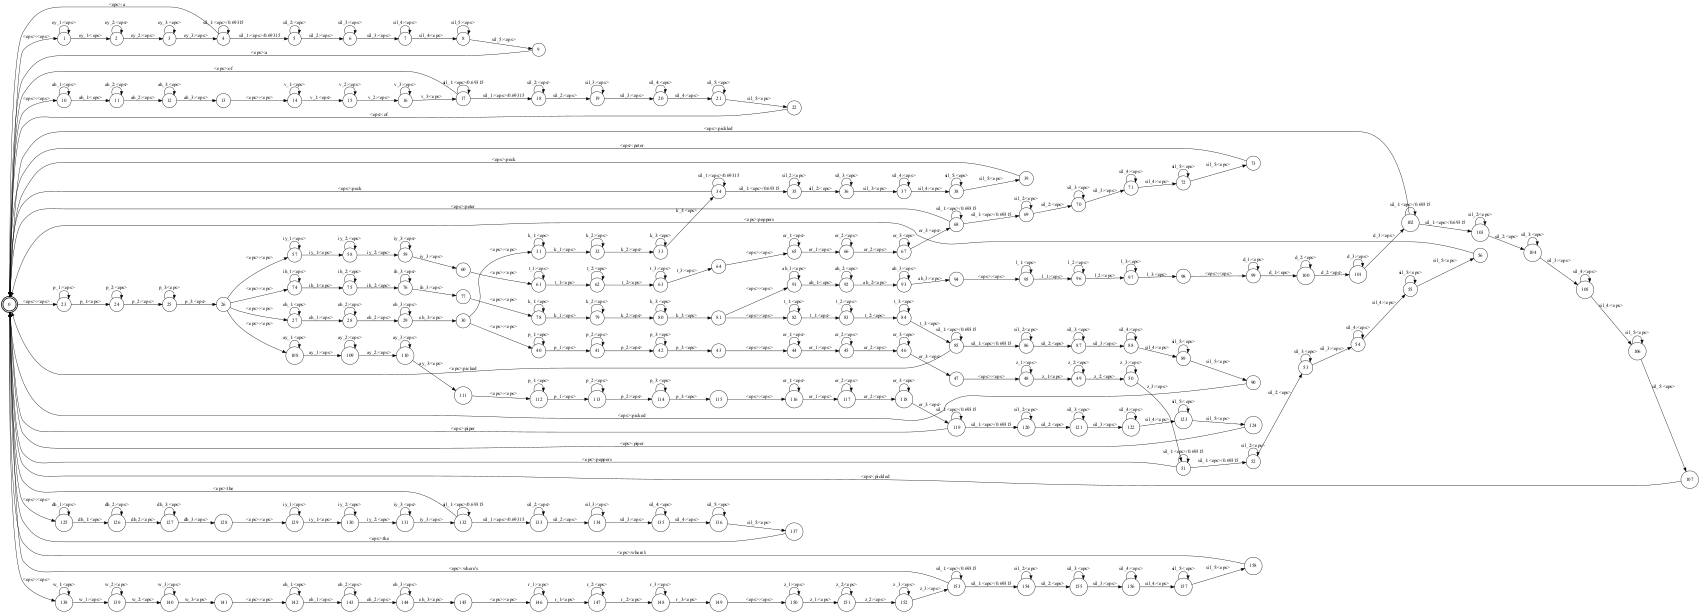

In [39]:
#task 4 tree structure diagrams
def generate_phone_wfst_tree(f, start_state, phone, n):
    """
    Generate a WFST representing an n-state left-to-right phone HMM.
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assumed to exist already
        phone (str): the phone label 
        n (int): number of states of the HMM excluding start and end
        
    Returns:
        the final state of the FST
    """
    
    current_state = start_state
    
    for i in range(1, n+1):
    
        in_label = state_table.find('{}_{}'.format(phone, i))
        sl_weight = fst.Weight('log', -math.log(1))
        # self-loop back to current state
        f.add_arc(current_state, fst.Arc(in_label, 0, sl_weight, current_state))
        
        # transition to next state
        
        # we want to output the phone label on the final state
        # note: if outputting words instead this code should be modified
        
        out_label = 0   # output empty <eps> label
            
        next_state = f.add_state()
        next_weight = fst.Weight('log', -math.log(1))
        f.add_arc(current_state, fst.Arc(in_label, out_label, next_weight, next_state))    
       
        current_state = next_state
    return current_state


def generate_tree_wfst(lex,sil_prob=0.5,next_state_prob=0.5):
    """Express the  in WFST form.

    Args:
        lex (dict): lexicon to use, created from the parse_lexicon() function.
    
    Returns:
        the constructed lexicon WFST.
    """
    silent_state_table = deepcopy(state_table)
    for i in range(1, 6):
        silent_state_table.add_symbol('sil_{}'.format(i))

    L = fst.Fst('log')
    
    # Create a single start state
    start_state = L.add_state()
    L.set_start(start_state)
    L.set_final(start_state)
    
    # Dictionary to check if an arc already exists (current_state, phone) -> next_state
    state_transitions = {}
    
    for word, pron in lex.items():
        
        
        current_state = start_state
        for i, phone in enumerate(pron):
            # Check if this (state, phone) pair has an existing next state
            if (current_state, phone) in state_transitions:
                next_state = state_transitions[(current_state, phone)]
            else:
                next_state= L.add_state()
                L.add_arc(current_state, fst.Arc(0,0, fst.Weight('log',-math.log(1)), next_state))
                c_state=next_state
                
                next_state = generate_phone_wfst_tree(L, c_state, phone, 3)
                state_transitions[(current_state, phone)] = next_state
                
                
            
            current_state = next_state
                          
        
        L.add_arc(current_state, fst.Arc(0,word_table.find(word) , fst.Weight('log',-math.log(1)), start_state))  
        weight = fst.Weight('log',-math.log(sil_prob*(1)))
         
        L.add_arc(current_state,fst.Arc(silent_state_table.find('sil_1'),0,weight,current_state))
        next_state =L.add_state()
        weight = fst.Weight('log',-math.log(sil_prob*((1))))
        L.add_arc(current_state,fst.Arc(silent_state_table.find('sil_1'),0,weight,next_state))
        current_state=next_state
        
        
        for i in range(2,6):
            weight = fst.Weight('log',-math.log(1))
            L.add_arc(current_state,fst.Arc(silent_state_table.find('sil_{}'.format(i)),0,weight,current_state))
            next_state =L.add_state()
            weight = fst.Weight('log',-math.log(1))
            L.add_arc(current_state,fst.Arc(silent_state_table.find('sil_{}'.format(i)),0,weight,next_state))
            current_state=next_state
        print(word, word_table.find(word))

            
            
            
            
            
        
        
        
        next_weight = fst.Weight('log', -math.log(1))
        L.add_arc(current_state, fst.Arc(0, word_table.find(word),next_weight , start_state))
        
        
        
        
    L.set_input_symbols(silent_state_table)
    L.set_output_symbols(word_table)                      
    
    return L

L = generate_tree_wfst(lex)
L.arcsort()

def generate_probability_tree(lex, probabilities):
    f = fst.Fst('log')
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    f.set_final(start_state)
    start_weight= fst.Weight('log', -math.log(1))
    for word, phones in lex.items():
        if probabilities:
            start_weight = fst.Weight('log', -math.log(probabilities[word]))
        current_state = f.add_state()
        f.add_arc(start_state, fst.Arc(0, 0,start_weight , current_state))
        
        
        # note: new current_state is now set to the final state of the previous phone WFST
        
        next_weight = fst.Weight('log', -math.log(1))
        out_label = word_table.find(word)
        f.add_arc(current_state, fst.Arc(0, out_label,next_weight , start_state))

    f.set_input_symbols(state_table)
    f.set_output_symbols(word_table)

    return f




draw_fst(L)
    

    
        


In [ ]:

Ldet = fst.determinize(L)
draw_fst(Ldet)

In [ ]:
f=create_wfst(3)


In [ ]:

print(num_states(f))
print(total_num_arcs(f))
f=generate_tree_wfst(3,)
results_df=[]
for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
                                                                      # audio files
    decoder = MyViterbiDecoder(f, wav_file)
    
    forward_computations, decode_speed = decoder.decode()
    print(decode_speed)
    (state_path, words, backtrace_speed) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
    # to return the words along the best path
    print(backtrace_speed)
    
    transcription = read_transcription(wav_file)
    
    word_count = len(transcription.split())
    



    
    error_counts = wer.compute_alignment_errors(transcription, words)
    word_count = len(transcription.split())
    worderror = sum(error_counts)/word_count
         # you'll need to accumulate these to produce an overall Word Error Rate
    filename = wav_file.split('/')[-1]
    row = {
        'Filename': filename,
        'Insertions': error_counts[2],
        'Deletions': error_counts[1],
        'Substitutions': error_counts[0],
        'WER': worderror,
        'Word Count': word_count,
        'transcription':transcription,
        'Viterbi transcription':words,
        'Decode speed': decode_speed,
        'Backtrace speed': backtrace_speed,
        'Forward computations': forward_computations
    }
    print(row)
    
    
    # Append results to the DataFrame
    results_df.append(row)
    
    
results_df = pd.DataFrame(results_df)
# Save the DataFrame to a CSV file
results_df.to_csv('result_silent_new.csv')



In [ ]:
from copy import deepcopy
def create_wfst_silent_word(n, probabilities=None, next_state_prob=0.5, sil_prob=0.5):
    """ Generate a WFST for any word in the lexicon, composed of n-state phone WFSTs."""
    silent_state_table = deepcopy(state_table)
    for i in range(1, 6):
        silent_state_table.add_symbol('sil_{}'.format(i))


    f = fst.Fst('log')
    
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)
    f.set_final(start_state)
    start_weight= fst.Weight('log', -math.log(1))
    for word, phones in lex.items():
        out_label = word_table.find(word)
        if probabilities:
            start_weight = fst.Weight('log', -math.log(probabilities[word]))
        current_state = f.add_state()
        f.add_arc(start_state, fst.Arc(0, 0,start_weight , current_state))
        
        for phone in phones: 
            last_state = current_state
            current_state = generate_phone_wfst(f, current_state, phone, n,next_state_prob)
            
        weight = fst.Weight('log',-math.log(1-sil_prob))
        f.add_arc(current_state,fst.Arc(0,out_label,weight,start_state))
        weight = fst.Weight('log',-math.log(sil_prob*(1-next_state_prob)))
        f.add_arc(current_state,fst.Arc(silent_state_table.find('sil_{}'.format(i)),0,weight,current_state))
        next_state =f.add_state()
        weight = fst.Weight('log',-math.log(sil_prob*((1-next_state_prob))))
        f.add_arc(current_state,fst.Arc(silent_state_table.find('sil_{}'.format(i)),0,weight,next_state))
        current_state=next_state
        
        
        for i in range(2,6):
            weight = fst.Weight('log',-math.log(1-next_state_prob))
            f.add_arc(current_state,fst.Arc(silent_state_table.find('sil_{}'.format(i)),0,weight,current_state))
            next_state =f.add_state()
            weight = fst.Weight('log',-math.log(next_state_prob))
            f.add_arc(current_state,fst.Arc(silent_state_table.find('sil_{}'.format(i)),0,weight,next_state))
            current_state=next_state
        

            
            
            
            
            
        
        
        
        next_weight = fst.Weight('log', -math.log(1))
        f.add_arc(current_state, fst.Arc(0, out_label,next_weight , start_state))
    f.set_input_symbols(silent_state_table)
    f.set_output_symbols(word_table)


    return f


f=create_wfst_silent_word(3,next_state_prob=0.1,sil_prob=0.5)
draw_fst(f)